***Importing Essential Modules***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.datasets import cifar10

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
import skimage

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize



***Class definitions for Hog transforming and gray scaling***

In [2]:
class RGB_to_Gray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
class Hogger(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block, block_norm=self.block_norm)
        return np.array([local_hog(img) for img in X])


***Loading CIFAR10 dataset through tensorflow***

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

***Visualizing The Data***

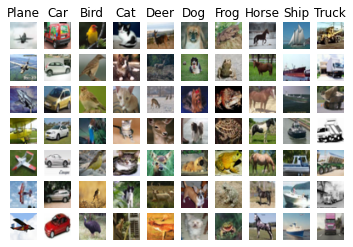

In [19]:
All_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
for x, cls in enumerate(All_classes):
    indexes = np.flatnonzero(y_train == x)
    indexes = np.random.choice(indexes, 7, replace=False)
    for i, index in enumerate(indexes):
        plt_index = i*10 + x + 1
        plt.subplot(7, 10, plt_index)
        plt.imshow(x_train[index].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

***Applying hog transformation and gray scaling to reduce the RGB parameters***

In [20]:
grayer = RGB_to_Gray()
hoger = Hogger(pixels_per_cell=(8, 8),cells_per_block=(2,2),orientations=9,block_norm='L2-Hys')
scaler = StandardScaler()
 
x_train2 = grayer.fit_transform(x_train)
x_train2 = hoger.fit_transform(x_train2)
x_train2 = scaler.fit_transform(x_train2)

x_test2=grayer.transform(x_test)
x_test2=hoger.transform(x_test2)
x_test2 = scaler.transform(x_test2)


***Reducing the training samples to 10k and testing samples to 1k***

In [21]:
train_size = 100
test_size = 10
x_train2 = x_train2[:train_size]
x_test2 = x_test2[:test_size]
y_train2 = y_train[:train_size].ravel()
y_test2 = y_test[:test_size].ravel()

***Implemetation of KNearestNeighbour classifier***

In [22]:
class KNN:
  def __init__(self, k=3):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y
    
  def euclidean_distance(self, x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

  def get_neighbours(self,X):
    neighbours = []
    for i in range(len(self.X_train)):
       dist = self.euclidean_distance(self.X_train[i],X)
       neighbours.append([dist,self.y_train[i]])
    return sorted(neighbours)
  
  def get_knearest(self,a):
    return [int(a[i][1]) for i in range(self.k)]

  def predict(self,X_test):
    y_pred = []
    for i in X_test:
      knn = self.get_knearest(self.get_neighbours(i))
      y_pred.append(max(set(knn),key=knn.count))
    return y_pred

  def predict2(self,X_test):
    y_pred = [[] for i in range(1,22,2)]
    for i in X_test:
      knn = self.get_knearest(self.get_neighbours(i))
      for i in range(1,22,2):
        a = knn[:i]
        y_pred[i//2].append(max(set(a),key=a.count))
    return y_pred


***KNN test for k=5***

In [23]:
classifier = KNN(k=5)
classifier.fit(x_train2,y_train2)

In [24]:
y_pred = classifier.predict(x_test2)
print(accuracy_score(y_test2,y_pred))

0.1


In [25]:
print(confusion_matrix(y_test2,y_pred))

[[0 1 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 1 0 0 0 1]]


***Running RFold-Cross-Validation with R=5***

In [26]:
r = 5
x_train_folds = []
y_train_folds = []

x_train_folds = np.array(np.array_split(x_train2,r))
y_train_folds = np.array(np.array_split(y_train2,r))

d = dict()
for i in range(1,22,2):
  d[i] = []

for i in range(r):
  x_valid = x_train_folds[i]
  y_valid = y_train_folds[i]
  x_train3 = x_train_folds
  y_train3 = y_train_folds
  
  temp = np.delete(x_train3,i,0)
  x_train3 = np.concatenate((temp),axis = 0)
  temp = np.delete(y_train3,i,0)
  y_train3 = np.concatenate((temp),axis = 0)
  
  classifier = KNN(k=21) 
  classifier.fit(x_train3,y_train3)
  y_pred = classifier.predict2(x_valid)
  for j in range(11):
    d[j*2+1].append(accuracy_score(y_valid,y_pred[j]))  


In [37]:
for i in d:
  print("k = {} : accuracies = {}".format(i,d[i]))

k = 1 : accuracies = [0.15, 0.2, 0.1, 0.15, 0.35]
k = 3 : accuracies = [0.2, 0.1, 0.15, 0.2, 0.3]
k = 5 : accuracies = [0.15, 0.2, 0.15, 0.2, 0.35]
k = 7 : accuracies = [0.1, 0.1, 0.25, 0.15, 0.25]
k = 9 : accuracies = [0.1, 0.1, 0.25, 0.15, 0.2]
k = 11 : accuracies = [0.15, 0.1, 0.25, 0.1, 0.2]
k = 13 : accuracies = [0.1, 0.05, 0.2, 0.15, 0.25]
k = 15 : accuracies = [0.2, 0.05, 0.2, 0.15, 0.3]
k = 17 : accuracies = [0.2, 0.05, 0.15, 0.15, 0.3]
k = 19 : accuracies = [0.15, 0.1, 0.2, 0.15, 0.3]
k = 21 : accuracies = [0.25, 0.05, 0.2, 0.15, 0.3]


***Finding Optimal K value***

In [28]:
ans = 0
m = 0
for i in d:
  if sum(d[i])>m:
    m = sum(d[i])
    ans = i
print("optimal k value = ",ans)

optimal k value =  5


***Confusion Matrix and traing,testing errors for Optimal K***

In [29]:
classifier = KNN(k=ans)
classifier.fit(x_train2,y_train2)
y_pred = classifier.predict(x_test2)
cm = confusion_matrix(y_test2,y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[0 1 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 2 0 0]
 [0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 1 0 0 0 1]]


In [30]:
print(accuracy_score(y_test2,y_pred))

0.1


In [31]:
print("Testing Error {}".format(1-accuracy_score(y_test2,y_pred)))
y_pred = classifier.predict(x_train2)
print("Training Error {}".format(1-accuracy_score(y_train2,y_pred)))

Testing Error 0.9
Training Error 0.47


***Precision-Recall curve for the optimal K value across all the classes***

In [32]:
y_train2 = label_binarize(y_train2, classes=[*range(10)])
y_test2 = label_binarize(y_test2, classes=[*range(10)])   
from sklearn.neighbors import KNeighborsClassifier 
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = ans))
clf.fit(x_train2,y_train2)
y_score = clf.predict_proba(x_test2)

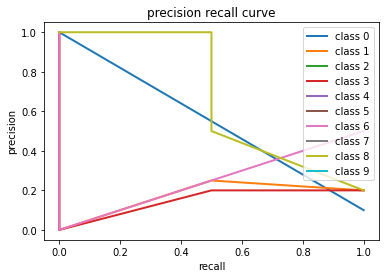

In [33]:
precision = dict()
recall = dict()
for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(y_test2[:, i],y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision recall curve")
plt.show()